<a href="https://colab.research.google.com/github/Polinia/skillfactory_rds/blob/main/module_4/_Project4_(credit_scoring).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The goal
Build a scoring model for a bank's secondary customers that predicts the likelihood of a customer defaulting. To do this, it will be necessary to define meaningful measurement parameters.

# Import libraries and data

In [114]:
# Import libraries
from pandas import Series
import pandas as pd
import numpy as np
%matplotlib inline
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = '/kaggle/input/sf-dst-scoring/'"""
import warnings
warnings.simplefilter('ignore')

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
# initial data
df_train = pd.read_csv('/train.csv')
df_test = pd.read_csv('/test.csv')

In [117]:
# functions
# the function of outliers count
def get_outliers(column):
    perc_25 = df[column].quantile(0.25, interpolation="midpoint")
    perc_75 = df[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    min_out = perc_25 - 1.5 * IQR
    max_out = perc_75 + 1.5 * IQR
    print('Total outliers: {} '.format(
        df[df[column] > max_out][column].count()+df[df[column] < min_out][column].count()))

# logarithm function
def log_values(x):
    if x > 0: #logarithm only applies to positive numbers
        x = np.log((x)+1)
    return x


In [118]:
print("Nulls in the train set:", df_train.isnull().sum(), sep ='\n')
print("Nulls in the test set:", df_test.isnull().sum(), sep ='\n')

Nulls in the train set:
client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64
Nulls in the test set:
client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64


In [119]:
# initial analysis
pd.set_option('display.max_columns', None)
print('Dimension of the training dataset: ', df_train.shape)
display(df_train.head(5))
print('Dimension of the testing dataset: ', df_test.shape)
display(df_test.head(5))
# in the test set there is no feauture 'default'

Dimension of the training dataset:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Dimension of the testing dataset:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [120]:
# combining training and test data into one dataset
df_train['train'] = 1 # note training set
df_test['train'] = 0 # note testing set
df = pd.concat([df_train, df_test], ignore_index=True)

In [121]:
df.info()
# missing some data in 'education'
# need to decide what to do with the missed data in the default column that happened after the join

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [122]:
# using the module for quick analysis of primary data
# pandas_profiling.ProfileReport(df)

Brief summary: in the training sample 73799 clients, in the test sample - 36349. In total, dataset consists 110148 clients. There are 20 values in total, 1 of them is a date that should be processed first. All missed data are in the feature 'education'. Missing data is in the attribute default appeared artificially. Also, 'Train' feature was added to indicate the ownership of the data and the subsequent separation.

# Предобработка

In [123]:
# I will get rid of missing values, given that the data in the education column is
# categorical I will change to mode.
# Although we can create another category 'no data'
df.education = df.education.apply(
    lambda x: df.education.mode()[0] if pd.isna(x) == True else x)

In [124]:
# will do the same with 'default'
df.default = df.default.apply(
    lambda x: df.default.mode()[0] if pd.isna(x) == True else x)

In [125]:
# checking
print(df.isna().sum())
print(df.info())

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
train               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7  

In [126]:
# will work with 'app_date'
# convert the date format to a convenient one to work with
df.app_date = pd.to_datetime(df.app_date)
display(df.app_date.sample(5))

479      2014-04-08
1584     2014-03-16
106540   2014-04-22
68845    2014-04-08
109450   2014-02-06
Name: app_date, dtype: datetime64[ns]

In [127]:
# Finding out the beginning and the end of the period of our dataset
# Probably all data is 2014 only
print("Beginning:", df.app_date.min(), "End:", df.app_date.max())

Beginning: 2014-01-01 00:00:00 End: 2014-04-30 00:00:00


In [128]:
# create simple new features based on 'date'
df['app_day'] = df.app_date.dt.day
df['app_month'] = df.app_date.dt.month
df['app_year'] = df.app_date.dt.year
df["app_weekday"] = df["app_date"].dt.weekday

# also will create a feauture containing the number of days elapsed since the start of observations,
# i.e. from January 1, 2014
df["app_number_days"] = (df["app_date"] - df.app_date.min()).dt.days.astype('int')

In [129]:
# checking if it's only 2014
print(df.app_year.unique())

[2014]


In [130]:
# dropuing features app_year and app_date
df.drop(["app_date", "app_year"], axis=1, inplace=True)

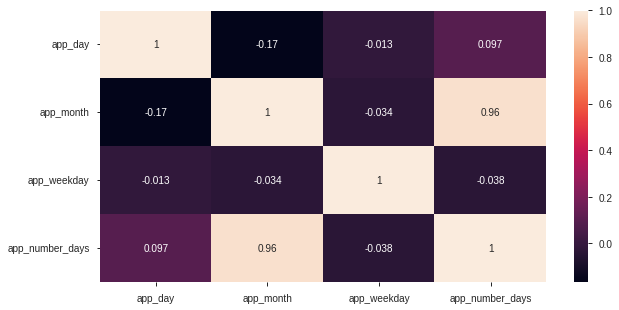

In [131]:
# checking if there are any redundant features using the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df.iloc[:,19:].corr(), annot=True)
# we can drop 'app_month' because it has a high correlation with 'app_number_days'

In [132]:
df.drop(["app_month"], axis=1, inplace=True)

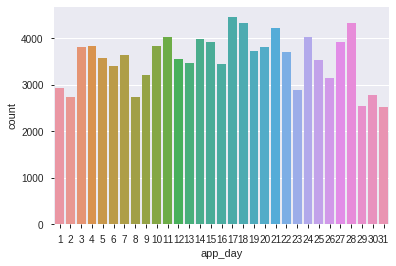

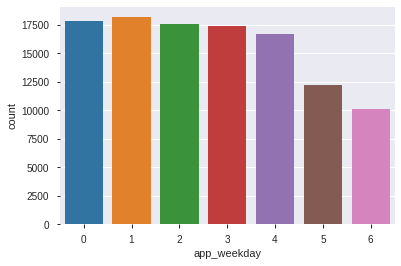

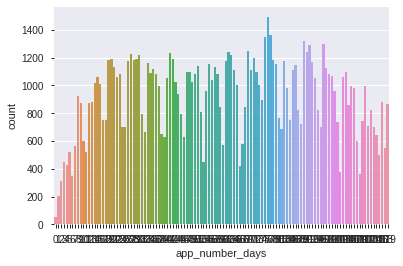

In [133]:
# look at the data distribution, leave it like that for the model
for i in df.iloc[:,19:].columns:
    sns.countplot(x = df[i], data = df)
    plt.show()

In [134]:
# for convenience, let's break the features into lists
# numeric
num_cols = ["age", "decline_app_cnt", "score_bki",
            "bki_request_cnt", "income", "app_day", "app_weekday", "app_number_days"]

# binary, the number of unique values which is equal two
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# categorical
cat_cols = ["education", "region_rating",
            "home_address", "work_address", "sna", "first_time"]
# client_id is dropped, it has unique values 
# default and train are also dropped

**Работа с числовыми признаками**

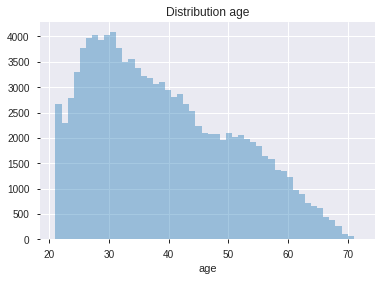

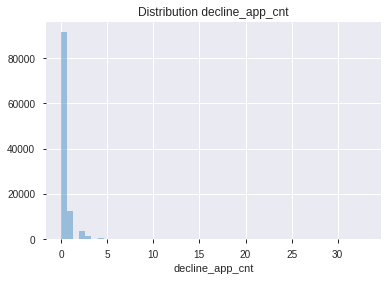

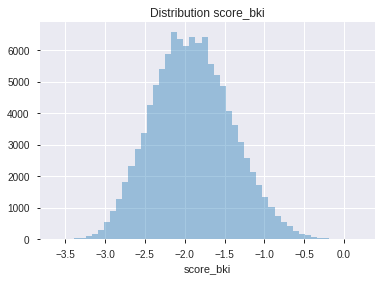

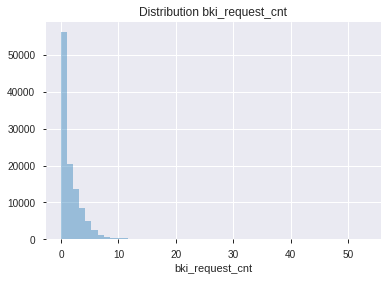

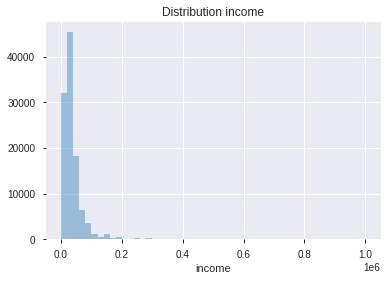

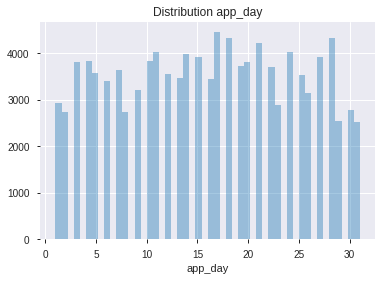

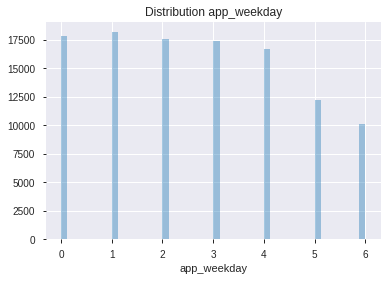

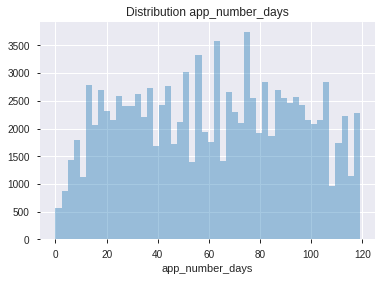

In [135]:
# analyses of the distribution of numerical variables using visualization
for col in num_cols:
    plt.figure()
    plt.title(f"Distribution {col}")
    sns.distplot(df[col], kde=False)
# features age, decline_app_cnt, bki_request_cnt and income worth taking a logarithm

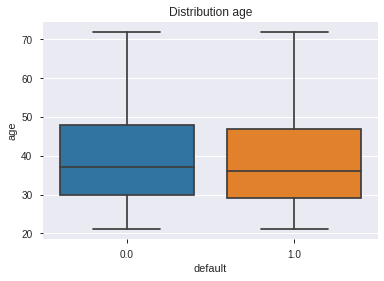

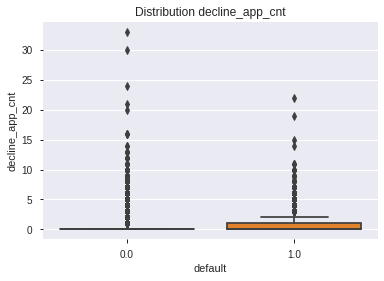

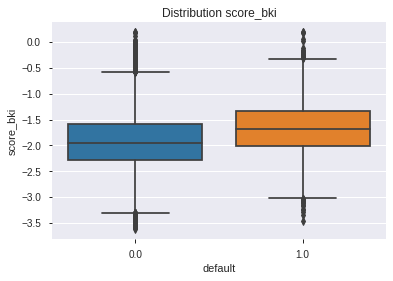

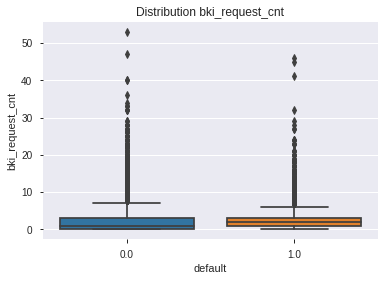

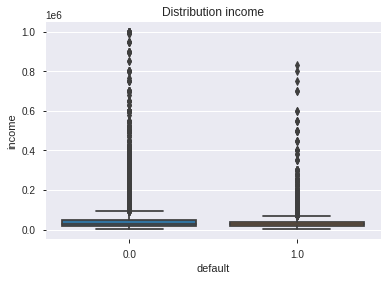

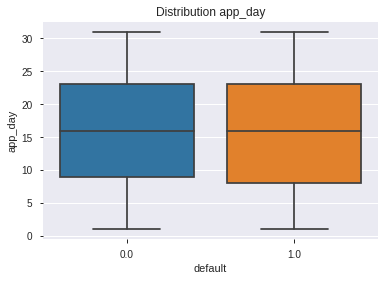

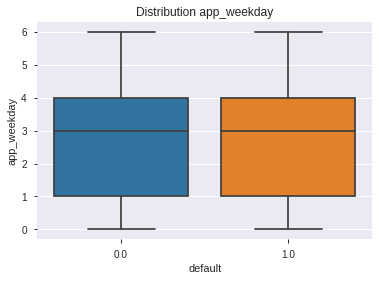

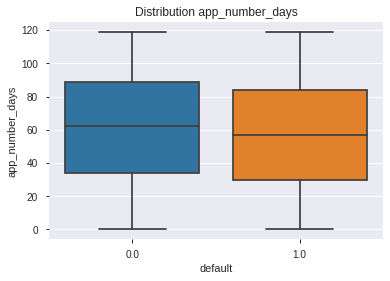

In [136]:
# look at outliers with boxplots
# we should pay attention to 'decline_app_cnt', 'score_bki', 'bki_request_cnt'
# in 'income' column, these are probably no outliers just good incomes
for col in num_cols:
    plt.title(f"Distribution {col}")
    sns.boxplot(x='default',y = col,data=df)
    plt.show()

In [137]:
# find out the number of outliers before processing
print(get_outliers(['decline_app_cnt']))
print(get_outliers(['income']))
print(get_outliers(['bki_request_cnt']))

Total outliers: decline_app_cnt    18677
dtype: int64 
None
Total outliers: income    7000
dtype: int64 
None
Total outliers: bki_request_cnt    2636
dtype: int64 
None


In [138]:
# taking logarithm
df['income'] = df.income.apply(log_values)
df['age'] = df.age.apply(log_values)
df['bki_request_cnt'] = df.bki_request_cnt.apply(log_values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd38099aa90>,
      dtype=object)

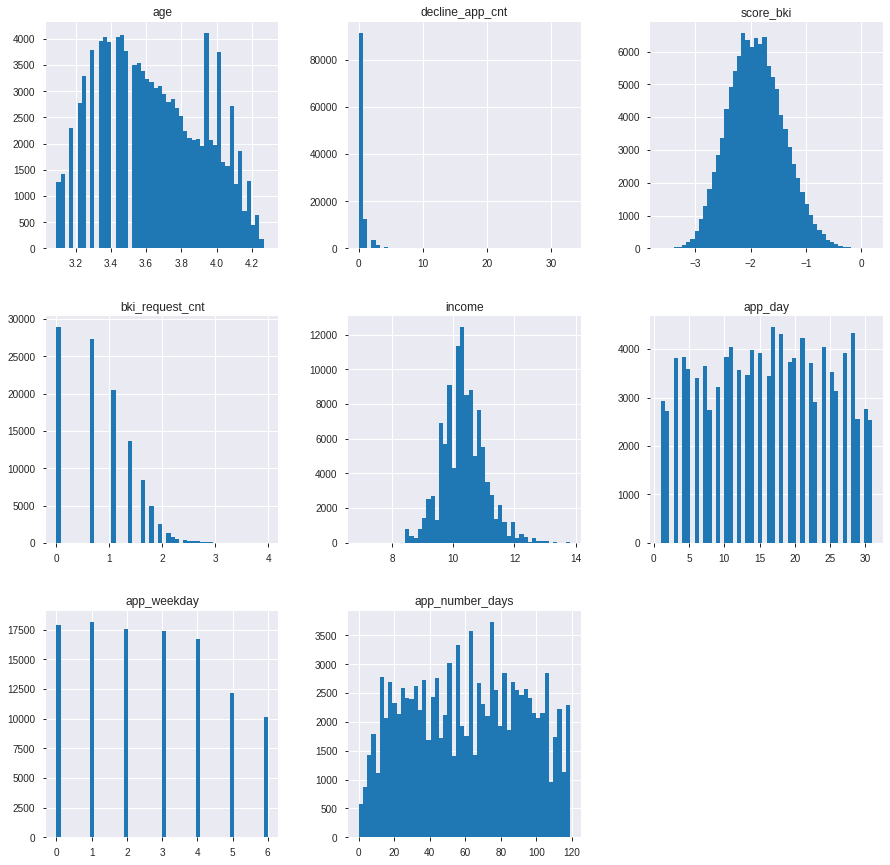

In [139]:
# destribution after taking the logarithm
df[num_cols].hist(
    figsize=(15, 15), bins=50)

In [140]:
# find out the number of missing data after the processing
print(get_outliers(['decline_app_cnt']))
print(get_outliers(['income']))
print(get_outliers(['bki_request_cnt']))

Total outliers: decline_app_cnt    18677
dtype: int64 
None
Total outliers: income    2609
dtype: int64 
None
Total outliers: bki_request_cnt    15
dtype: int64 
None


We have successfully taken the logarithm of the required features, which also had a positive effect on the number of outliers in these features. 
Conclusions:
* Defaulted clients are younger on average
* Defaulted clients have a large number of canceled requests on average
* Default clients on average have more requests to BKI
* Defaulted customers have lower income on average

Дальнейшие действия:
* We will not do anything with outliers in the 'income' and 'score_bki' features (because these are probably useful outliers)
* Let's move 'decline_app_cnt' into a categorical feature and get rid of outliers at the same time

In [141]:
#let's look at the distribution of 'decline_app_cnt'
df.decline_app_cnt.value_counts()
# most of the values ​​takes 0 (which means there were no refusals before)

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
24        1
30        1
21        1
19        1
15        1
33        1
22        1
20        1
Name: decline_app_cnt, dtype: int64

In [142]:
# make the feature categorical
# all values of past refusals greater than 3 are equal 3
df.decline_app_cnt = df.decline_app_cnt.apply(lambda x: x if x < 3 else 3)

In [143]:
# making changes
num_cols.remove("decline_app_cnt")
cat_cols.append('decline_app_cnt')

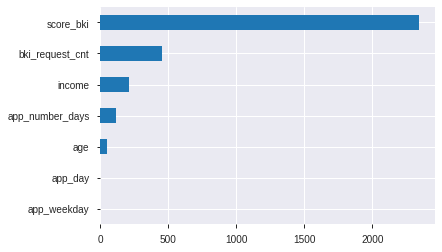

In [144]:
# check the significance of numeric variables
# use one-way analysis of variance (ANOVA) to evaluate:
temp_df = df[df['train']==1]
imp_num = Series(f_classif(temp_df[num_cols], temp_df['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Conclusions: the most significant feature is 'score_bki' (it is the scoring score according to the data from the BKI, it may be better to delete the 'app_day' and 'app_weekday' features, we will decide this after further research)

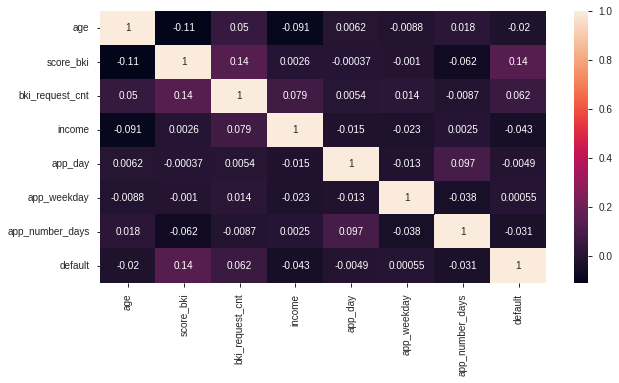

In [145]:
# build a correlation matrix for numerical features
plt.figure(figsize=(10,5))
sns.heatmap(df[num_cols+['default']].corr(), annot=True)
# matrix confirms previous findings
# in general, the data is suitable for inclusion into the model

**Работа с бинарными признаками**

In [146]:
# conversion with LabelEncoder()
label_encoder = LabelEncoder()
# before encoding, fix the labeling of values
for i in bin_cols:
    mapped = pd.Series(label_encoder.fit_transform(df[i]))
    print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'Y'}
{0: 0, 1: 1}
{0: 'N', 1: 'Y'}


In [147]:
# conversion with LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# make sure the transformation
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_day,app_weekday,app_number_days
0,25905,SCH,1,4.143135,1,1,0,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0.0,1,1,5,31
1,63161,SCH,0,4.094345,0,0,0,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0.0,1,12,2,70
2,25887,SCH,1,3.258097,1,0,2,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0.0,1,1,5,31
3,16222,SCH,0,3.988984,0,0,0,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0.0,1,23,3,22
4,101655,GRD,1,3.891820,0,0,0,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0.0,1,18,4,107


In [148]:
# will check and see the data distributionе one more time
# an interesting fact is women more likely apply for loans than men
display(df[i].value_counts())

0    93721
1    16427
Name: foreign_passport, dtype: int64

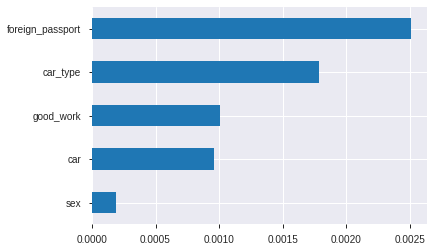

In [149]:
# Let's check the significance of binary variables:
temp_df = df[df['train']==1]
imp_bin = Series(mutual_info_classif(temp_df[bin_cols], temp_df['default'],
                                     discrete_features=True), index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

**Working with categorical features**

In [150]:
# convert the data of 'education' feature into numerical categories
mapped = pd.Series(label_encoder.fit_transform(df['education']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


In [151]:
df['education'] = label_encoder.fit_transform(df['education'])
df.sample(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_day,app_weekday,app_number_days
102530,103416,3,0,3.178054,0,0,0,0,-1.718275,1.791759,50,2,3,9.680406,4,3,0,0.0,0,21,0,110
20953,75393,3,0,3.663562,0,0,2,0,-1.282395,1.098612,50,1,3,9.472782,1,3,0,0.0,1,23,6,81
52243,98150,1,1,3.367296,0,0,0,0,-2.206896,0.693147,70,2,3,10.714440,1,4,0,0.0,1,15,1,104


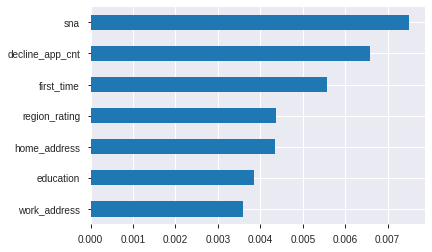

In [152]:
# Let's check the significance of category variables:
temp_df = df[df['train']==1]
imp_cat = Series(mutual_info_classif(temp_df[cat_cols], temp_df['default'],
                                     discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Conclusion: the influence of features looks logical, all signs matter, we will not delete them.

# Future Engeneering

In [153]:
# implement OneHotEncoding for categorical features
df = pd.get_dummies(df, columns = cat_cols)

In [154]:
# remove unnecessary variables
num_cols.remove('app_day')
num_cols.remove('app_weekday')
df.drop(['app_day', 'app_weekday'], axis=1, inplace=True)

In [155]:
df

,client_id,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,train,app_number_days,education_0,education_1,education_2,education_3,education_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3
0,25905,1,4.143135,1,1,0,-2.008753,0.693147,9.798183,0,0.0,1,31,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
1,63161,0,4.094345,0,0,0,-1.532276,1.386294,9.852247,0,0.0,1,70,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0
2,25887,1,3.258097,1,0,0,-1.408142,0.693147,10.308986,1,0.0,1,31,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
3,16222,0,3.988984,0,0,0,-2.057471,1.098612,9.210440,0,0.0,1,22,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0
4,101655,1,3.891820,0,0,1,-1.244723,0.693147,10.308986,1,0.0,1,107,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,0,3.637586,0,0,0,-1.744976,1.386294,9.615872,0,0.0,0,89,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0
110144,106254,0,4.174387,1,1,0,-2.293781,1.386294,12.206078,0,0.0,0,114,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0
110145,81852,1,3.465736,0,0,0,-0.940752,0.693147,11.002117,0,0.0,0,88,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
110146,1971,0,3.332205,0,0,0,-1.242392,1.098612,10.308986,0,0.0,0,6,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0


In [156]:
# let's add new polynomial features, 
# which are mathematical combinations of numerical features
pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(df[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
df = df.join(poly_df,  how='left')

In [157]:
df.head()

,client_id,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,train,app_number_days,education_0,education_1,education_2,education_3,education_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3,x0^2,x0 x1,x0 x2,x0 x3,x0 x4,x1^2,x1 x2,x1 x3,x1 x4,x2^2,x2 x3,x2 x4,x3^2,x3 x4,x4^2
0,25905,1,4.143135,1,1,0,-2.008753,0.693147,9.798183,0,0.0,1,31,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,17.165565,-8.322534,2.871802,40.595191,128.437177,4.035088,-1.392361,-19.682128,-62.271341,0.480453,6.791583,21.487563,96.004382,303.743660,961.0
1,63161,0,4.094345,0,0,0,-1.532276,1.386294,9.852247,0,0.0,1,70,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,16.763657,-6.273667,5.675967,40.338493,286.604119,2.347870,-2.124186,-15.096364,-107.259335,1.921812,13.658114,97.040605,97.066769,689.657282,4900.0
2,25887,1,3.258097,1,0,0,-1.408142,0.693147,10.308986,1,0.0,1,31,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,10.615193,-4.587863,2.258340,33.587672,101.000993,1.982865,-0.976050,-14.516519,-43.652410,0.480453,7.145645,21.487563,106.275192,319.578566,961.0
3,16222,0,3.988984,0,0,0,-2.057471,1.098612,9.210440,0,0.0,1,22,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,15.911994,-8.207220,4.382347,36.740300,87.757649,4.233188,-2.260363,-18.950217,-45.264369,1.206949,10.118703,24.169470,84.832212,202.629688,484.0
4,101655,1,3.891820,0,0,1,-1.244723,0.693147,10.308986,1,0.0,1,107,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,15.146265,-4.844237,2.697604,40.120721,416.424772,1.549335,-0.862776,-12.831829,-133.185333,0.480453,7.145645,74.166748,106.275192,1103.061501,11449.0


# Building the model

In [158]:
def count_metrics(y_test, y_pred, y_proba):    
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['f1'] = f1_score(y_test, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_test, y_probs)  
    metrics['confusion'] = confusion_matrix(y_test, y_pred)
    return metrics 

In [159]:
# we split the sample by indicators in 'train'
df_train = df.query('train == 1').drop(['train'], axis=1)
df_test = df.query('train == 0').drop(['train'], axis=1)

In [160]:
# check for matching values
print("Training set:", df_train.shape,
      "Testing set:", df_test.shape, sep='\n')
# the number of lines matches the original

Training set:
(73799, 57)
Testing set:
(36349, 57)


In [161]:
# once again divide the training data into test and validation
X = df_train.drop(['default'], axis=1).values
Y = df_train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                      test_size=0.20, random_state=42)

**Model 1 - Simple model**

In [162]:
# let's train on this simple model
model_1 = LogisticRegression(solver = 'liblinear')
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
y_proba = model_1.predict_proba(X_test)[:,1]

In [163]:
# Metrics checking
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))
# low f1 mean we're in trouble

accuracy_score: 0.8762
f1_score: 0.0011
recall_score: 0.0005
MSE: 0.1238


In [164]:
#let's look at the Сonfusion Matrix
confusion_matrix(y_test, y_pred)
# looks like overfitting

array([[12931,     2],
       [ 1826,     1]])

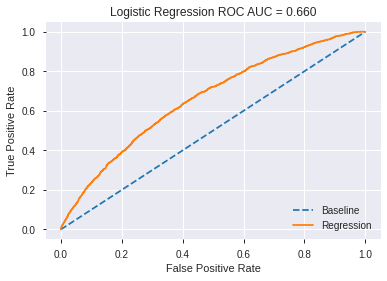

In [165]:
#Building ROC AUС


fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

**Model 2 - Oversampling**

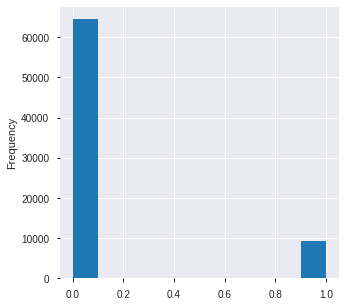

In [166]:
# Let's look at the distribution of the target feature 'default':
df_train['default'].plot(kind = 'hist',figsize=(5,5)) 
#there are significantly more customers without default 

In [167]:
#We clearly see the imbalance in the sample, in this case the model tends to overfit.
#Let's try to apply oversampling in this case to smooth out this difference.
zeroes = df_train[df_train['default']==0]
ones = df_train[df_train['default']==1]
default_new = int(len(zeroes)/len(ones))
for i in range(default_new):
    df_train = df_train.append(ones).reset_index(drop=True) 

In [168]:
# once again divide the training data into test and validation
X = df_train.drop(['default'], axis=1).values
Y = df_train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [169]:
# Training the model
model_1 = LogisticRegression(solver = 'liblinear')
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
y_proba = model_1.predict_proba(X_test)[:,1]

In [170]:
# checking metrics
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.6731
f1_score: 0.6785
recall_score: 0.6889
MSE: 0.3269


In [171]:
#looking at the Сonfusion Matrix
confusion_matrix(y_test, y_pred)
# it is worth admitting that the model after the transformation is better, but it is still worth to work on it

array([[8535, 4450],
       [4051, 8971]])

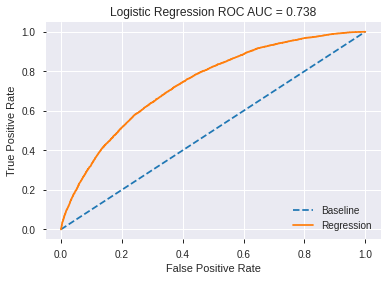

In [172]:
#building ROC AUС
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

**Model 3. Normalization and Oversampling**

In [173]:
#Normalization
df_train_balanced=df_train
num_cols_std = StandardScaler().fit_transform(df_train_balanced[num_cols].values)

# here we remove the old data and replace them with normalized ones
X = np.hstack([df_train_balanced.drop(num_cols + ['client_id','default'],
                                      axis=1), num_cols_std])
Y = df_train_balanced['default'].values

# splitting again
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                          test_size=0.20, random_state=42)

#Training 
model_std_balanced = LogisticRegression(solver = 'liblinear')
model_std_balanced.fit(X_train, y_train)
y_pred = model_std_balanced.predict(X_test)
y_proba = model_std_balanced.predict_proba(X_test)[:,1]

In [174]:
# checking metrics
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.6749
f1_score: 0.6797
recall_score: 0.6888
MSE: 0.3251


In [175]:
#looking at the Сonfusion Matrix
confusion_matrix(y_test, y_pred)

array([[8582, 4403],
       [4052, 8970]])

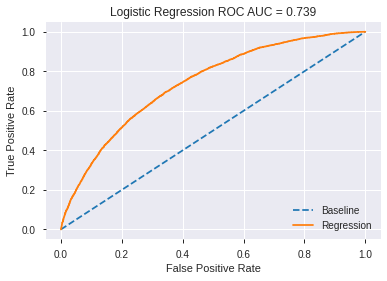

In [176]:
#building ROC AUС
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
# overall performance is better, but not significantly

**Model 4 - With selection of parameters**

In [177]:
import warnings
warnings.simplefilter('ignore')

In [178]:
# function for selecting the best parameters
def regularise(X_train, y_train):
    C = np.logspace(0, 4, 10)
    penalty = ['l1', 'l2']
    hyperparameters = dict(C=C, penalty=penalty)
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

    best_model = clf.fit(X_train, y_train)

    best_penalty = best_model.best_estimator_.get_params()['penalty']
    best_c = best_model.best_estimator_.get_params()['C']
    best_solver = best_model.best_estimator_.get_params()['solver']
    return best_penalty, best_c, best_solver

In [107]:
best_penalty, best_c, best_solver = regularise(X_train, y_train)
best_penalty, best_c, best_solver

('l2', 3593.813663804626, 'lbfgs')

In [108]:
# look at the model with the best parameters
model_finish = LogisticRegression(penalty='l2', C=2.7825594022071245, 
                  class_weight='balanced', max_iter=1000, solver = 'liblinear')
model_finish.fit(X_train, y_train)

y_pred = model_finish.predict(X_test)
y_proba = model_finish.predict_proba(X_test)[:,1]

In [109]:
# checking metrics
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.6744
f1_score: 0.6759
recall_score: 0.6782
MSE: 0.3256


In [110]:
# looking at the Сonfusion Matrix
confusion_matrix(y_test, y_pred)

array([[8707, 4278],
       [4191, 8831]])

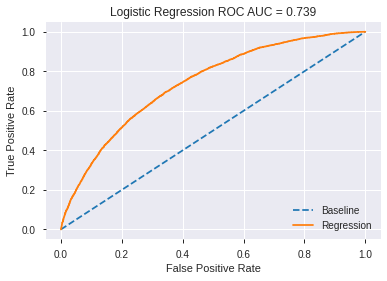

In [179]:
#building ROC AUС
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
# in general, the performance is better, let's stop there

Conclusion: we did a complex of standard manipulations to select the learning model and its best parameters. This made it possible to obtain decent and stable results in all parts of the sample.

# Submission

In [112]:
#calculation on balanced test data
num_cols_std = StandardScaler().fit_transform(df_test[num_cols].values)
X_test = np.hstack([df_test.drop(num_cols + ['client_id','default'],
                                 axis=1), num_cols_std])
y_probs = model_finish.predict_proba(X_test)[:,1]
df_test['default'] = y_probs

In [113]:
submission = df_test[['client_id','default']]
submission.to_csv('sample_submission.csv', index=False)
submission.sample(3)
#submission.shape

,client_id,default
99884,73361,0.540203
105966,6226,0.515809
78655,4976,0.201571
